In [1]:
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn

In [2]:
from qiskit import execute
from qiskit.circuit import Parameter,ControlledGate
from qiskit import Aer
import qiskit
import numpy as np

In [3]:
from tqdm import tqdm

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
np.random.seed = 42

NUM_QUBITS = 3
NUM_SHOTS = 3000
SHIFT = np.pi/4
LEARNING_RATE = 0.01
MOMENTUM = 0.5

SIMULATOR = Aer.get_backend('qasm_simulator')

In [6]:
import itertools
def create_QC_OUTPUTS():
    measurements = list(itertools.product([0, 1], repeat=NUM_QUBITS))
    return [''.join([str(bit) for bit in measurement]) for measurement in measurements]

QC_OUTPUTS = create_QC_OUTPUTS()
print(QC_OUTPUTS)

['000', '001', '010', '011', '100', '101', '110', '111']


In [7]:
class QiskitCircuit():
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self.circuit = qiskit.QuantumCircuit(n_qubits)
        self.n_qubits = n_qubits
        self.thetas ={k : Parameter('Theta'+str(k))for k in range(self.n_qubits)}
        
        all_qubits = [i for i in range(n_qubits)]
        self.circuit.h(all_qubits)
        self.circuit.barrier()
        for k in range(n_qubits):
            self.circuit.ry(self.thetas[k], k)
        

        self.circuit.measure_all()
        # ---------------------------
        
        self.backend = backend
        self.shots = shots
        
    def N_qubit_expectation_Z(self,counts, shots, nr_qubits):
        expects = np.zeros(len(QC_OUTPUTS))
        for k in range(len(QC_OUTPUTS)):
            key = QC_OUTPUTS[k]
            perc = counts.get(key, 0) /shots
            expects[k] = perc
        return expects
    
    def run(self, i):
        params = i
        backend = Aer.get_backend('qasm_simulator')
    
        bound_circuit = self.circuit.bind_parameters({self.thetas[k] : params[k].item() for k in range(NUM_QUBITS)}) 
        job_sim = execute(bound_circuit, self.backend, shots=self.shots)
         
        result_sim = job_sim.result()
        counts = result_sim.get_counts()
        return self.N_qubit_expectation_Z(counts,self.shots,NUM_QUBITS)

Expected value for rotation [pi/4]: [0.00433333 0.01433333 0.02133333 0.097      0.01633333 0.09233333
 0.10866667 0.64566667]


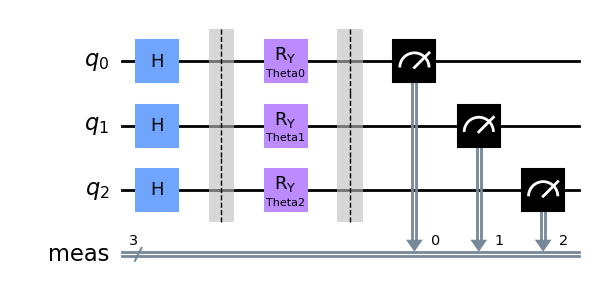

In [8]:
circuit = QiskitCircuit(NUM_QUBITS, SIMULATOR, NUM_SHOTS)
print('Expected value for rotation [pi/4]: {}'.format(circuit.run(torch.Tensor([np.pi/4]*NUM_QUBITS))))
circuit.circuit.draw(output='mpl')#, filename='Figures/{}-qubit circuit ryN.jpg'.format(NUM_QUBITS)

In [9]:
class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(NUM_QUBITS, SIMULATOR, shots=NUM_SHOTS)
            
        exp_value = ctx.QiskitCirc.run(i)
        
        result = torch.tensor([exp_value])
        
        
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        
        forward_tensor, i = ctx.saved_tensors
        input_numbers = i
        gradients = torch.Tensor()
        
        for k in range(NUM_QUBITS):
            shift_right = input_numbers.detach().clone()
            shift_right[k] = shift_right[k] + SHIFT
            shift_left = input_numbers.detach().clone()
            shift_left[k] = shift_left[k] - SHIFT
            
            expectation_right = ctx.QiskitCirc.run(shift_right)
            expectation_left  = ctx.QiskitCirc.run(shift_left)
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients = torch.cat((gradients, gradient.float()))
            
        result = torch.Tensor(gradients)

        return (result.float() * grad_output.float()).T

In [10]:
x = torch.tensor([np.pi/4]*NUM_QUBITS, requires_grad=True)

qc = TorchCircuit.apply
y1 = qc(x)
print('y1 after quantum layer: {}'.format(y1))
y1 = nn.Linear(2**NUM_QUBITS,1)(y1.float())
y1.backward()
print('x.grad = {}'.format(x.grad))

y1 after quantum layer: tensor([[0.0027, 0.0193, 0.0163, 0.1047, 0.0203, 0.1070, 0.1030, 0.6267]],
       dtype=torch.float64, grad_fn=<TorchCircuitBackward>)
x.grad = tensor([ 0.0652, -0.0146,  0.0441])


/tmp/ipykernel_22230/1768170039.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343964576/work/torch/csrc/utils/tensor_new.cpp:245.)
  result = torch.tensor([exp_value])


### FashionMNIST in pytorch

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [13]:
import numpy as np
import torchvision
from torchvision import datasets, transforms

n_samples = 150

X_train = datasets.FashionMNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 2)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 3)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 4)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 5)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 6)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 7)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]


train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True, pin_memory=True)

**Testing Data**

In [14]:
n_samples = 150

X_test = datasets.FashionMNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 2)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 3)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 4)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 5)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 6)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 7)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, NUM_QUBITS)
        self.qc = TorchCircuit.apply
        self.qcsim = nn.Linear(NUM_QUBITS, 1)
        self.fc3 = nn.Linear(1, 4)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = np.pi*torch.tanh(x)

        MODE = 'QC' 
    
        if MODE == 'QC': 
            x = qc(x[0]) # QUANTUM LAYER
        
        else:
            x = self.qcsim(x)

        x = torch.sigmoid(x)
        x = torch.cat((x, 1-x), -1)
        return x
    
    
    def predict(self, x):
        pred = self.forward(x)
        ans = torch.argmax(pred[0]).item()
        return torch.tensor(ans)
    
network = Net()
optimizer = optim.Adam(network.parameters(), lr=0.001)

In [16]:
total_params = sum(p.numel() for p in network.parameters() if p.requires_grad)
print("Number of trainable parameters:", total_params)

Number of trainable parameters: 21495


In [17]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=6):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(384 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 384 * 7 * 7)
        x = self.classifier(x)
        return x


In [18]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=6):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=16*4*4, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=num_classes)
        )
        
    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(-1, 16*4*4)  # Flatten the tensor
        logits = self.classifier(x)
        return logits


In [19]:
# Define the ensemble model
class Ensemble(nn.Module):
    def __init__(self, modelA, modelB):
        super(Ensemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB

    def forward(self, x):
        outA = self.modelA(x)
        outB = self.modelB(x)
        # Average the outputs
        return (outA + outB) / 2

In [20]:
device = torch.device("cpu")

# Instantiate models
alexnet_model = AlexNet(num_classes=8).to(device)  
lenet_model = LeNet5(num_classes=8).to(device)     

In [21]:
teacher_model = Ensemble(alexnet_model, lenet_model).to(device)
teacher_model.load_state_dict(torch.load("ensemble fashionmnist 0-7.pth"))
teacher_model.eval()

Ensemble(
  (modelA): AlexNet(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
    )
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): Linear(in_features=18816, out_features=4096, bias=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.5, inplace=False)
      (4): Linear(in_features=4096, out_features=4096, bias=True)
      (5): ReLU(inplace=True)
      (6): Linear(in_features=4096, out_features=8, bias=True)
    )
  )
  (modelB): LeNet5(
    (feature_extractor): Sequential(
     

In [22]:
def distillation_loss(y, teacher_scores, T=3.0, alpha=0.9):
    # Get the soft targets from the teacher model
    teacher_probs = F.softmax(teacher_scores / T, dim=1)
    # Calculate KL divergence
    kd_loss = nn.KLDivLoss()(F.log_softmax(y/T, dim=1), teacher_probs) * (T * T * 8 * alpha)
    return kd_loss


In [23]:
epochs = 10
loss_list = []
val_loss_list = []
loss_func = nn.CrossEntropyLoss()
best = 0

for epoch in range(epochs):
    network.train()
    
    total_loss = []
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
#         print(batch_idx)
        optimizer.zero_grad()        
        # Forward pass
        output = network(data)
        
        # Forward pass in teacher
        with torch.no_grad():
            output_teacher = teacher_model(data)
            
        # Calculating loss
        loss = loss_func(output, target)
        
        # Calculate the distillation loss using only first 6 outputs of student
        kd_loss = distillation_loss(output[:, :8], output_teacher)
        
        loss = loss + kd_loss
        
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
        
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))
    
    network.eval()
    
    accuracy = 0
    number = 0
    
    with torch.no_grad():
        total_val_loss = []
        for batch_idx, (data, target) in enumerate(test_loader):
            number +=1
            output = network(data)
            
            # Calculating loss
            loss = loss_func(output, target)
            
            output = network.predict(data).item()
            
            total_val_loss.append(loss.item())
        
            accuracy += (output == target[0].item())*1
            
        accuracy = 100*accuracy/number
        
        if accuracy > best:
            best = accuracy
            torch.save(network.state_dict(), 'distil t=ensemble s=fashion0-7 3qubits.pth')
            
        val_loss_list.append(sum(total_val_loss)/len(total_val_loss))
        print("Val loss: {} and accuracy = {}%".format(val_loss_list[-1],accuracy))

  0%|                                                  | 0/1200 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/new_env/lib/python3.9/site-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
100%|███████████████████████████████████████| 1200/1200 [01:42<00:00, 11.71it/s]


Training [10%]	Loss: 3.9524
Val loss: 2.6636360836027584 and accuracy = 52.75%


100%|███████████████████████████████████████| 1200/1200 [01:40<00:00, 12.00it/s]


Training [20%]	Loss: 3.9190
Val loss: 2.6511445121372508 and accuracy = 57.833333333333336%


100%|███████████████████████████████████████| 1200/1200 [01:40<00:00, 11.98it/s]


Training [30%]	Loss: 3.9012
Val loss: 2.6338471546327678 and accuracy = 67.41666666666667%


100%|███████████████████████████████████████| 1200/1200 [01:40<00:00, 11.99it/s]


Training [40%]	Loss: 3.8872
Val loss: 2.6319838223220007 and accuracy = 70.41666666666667%


100%|███████████████████████████████████████| 1200/1200 [01:39<00:00, 12.02it/s]


Training [50%]	Loss: 3.8833
Val loss: 2.6235447346231386 and accuracy = 72.58333333333333%


100%|███████████████████████████████████████| 1200/1200 [01:38<00:00, 12.12it/s]


Training [60%]	Loss: 3.8765
Val loss: 2.6229907903612695 and accuracy = 72.83333333333333%


100%|███████████████████████████████████████| 1200/1200 [01:39<00:00, 12.07it/s]


Training [70%]	Loss: 3.8792
Val loss: 2.6229804597573225 and accuracy = 72.5%


100%|███████████████████████████████████████| 1200/1200 [01:39<00:00, 12.04it/s]


Training [80%]	Loss: 3.8749
Val loss: 2.622089280694141 and accuracy = 74.41666666666667%


100%|███████████████████████████████████████| 1200/1200 [01:38<00:00, 12.17it/s]


Training [90%]	Loss: 3.8700
Val loss: 2.61827410082187 and accuracy = 74.08333333333333%


100%|███████████████████████████████████████| 1200/1200 [01:38<00:00, 12.20it/s]


Training [100%]	Loss: 3.8689
Val loss: 2.6150403554736403 and accuracy = 74.25%


In [24]:
print('Best accuracy = {}'.format(best))

Best accuracy = 74.41666666666667


In [25]:
def normalize_list(numbers):
    min_value = min(numbers)
    max_value = max(numbers)
    return [(x - min_value) / (max_value - min_value) for x in numbers]

loss_list = normalize_list(loss_list)
val_loss_list = normalize_list(val_loss_list)

/tmp/ipykernel_22230/2414873218.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


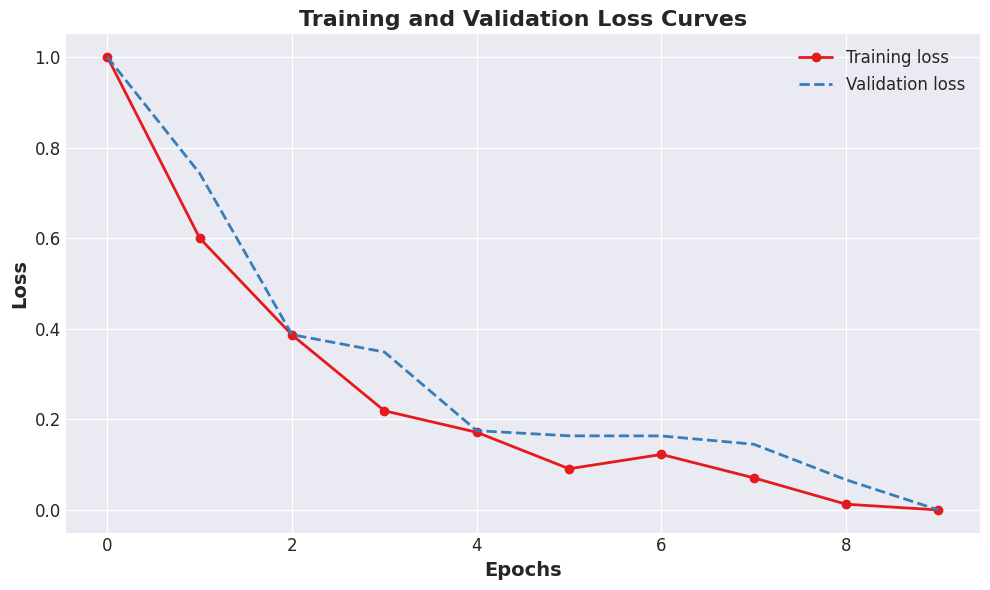

In [26]:
import matplotlib.pyplot as plt

# Use a professional style
plt.style.use('seaborn-darkgrid')

# Create a color palette
color_palette = plt.get_cmap('Set1')

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting both the curves simultaneously with enhanced aesthetics
ax.plot(loss_list, color=color_palette(0), marker='o', linestyle='-', linewidth=2, label='Training loss')
ax.plot(val_loss_list, color=color_palette(1), marker='', linestyle='--', linewidth=2, label='Validation loss')

# Naming the x-axis, y-axis and the whole graph with enhanced font properties
ax.set_xlabel("Epochs", fontsize=14, fontweight='bold')
ax.set_ylabel("Loss", fontsize=14, fontweight='bold')
ax.set_title("Training and Validation Loss Curves", fontsize=16, fontweight='bold')

# Displaying the legend with larger font size
ax.legend(fontsize=12)

# Enhance tick visibility and size
ax.tick_params(axis='both', which='major', labelsize=12)

# Adjust the plot for better layout
plt.tight_layout()

# Saving the graph in high quality
plt.savefig("distil t = ensemble s = fashionmnist 0-7 3qubits loss curve.png", dpi=300)

# Displaying the graph
plt.show()
